# QBUS2820 Assignment 1
In this project we want to develop a predictive model that accurately estimates the total time required to deliver an order, using a dataset containing variables such as distance, weather impact, and courier experience.

This model will help improve the efficiency of delivery operations for a logistics company by enabling better planning and resource allocation. By analyzing the data and applying different modeling techniques, the project aims to provide actionable insights that minimize delivery delays and enhance customer satisfaction.

### Read Data + Initial Data Exploration

Loading the data and observe the first few rows, data types, and basic statistics to identify any glaring issues like missing values or incorrect data types.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving DeliveryTime_training.csv to DeliveryTime_training.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer


sns.set(style="whitegrid")
training_data = pd.read_csv('DeliveryTime_training.csv')
training_data.describe(), training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4800 entries, 0 to 4799
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   DeliveryTime       4800 non-null   float64
 1   Distance           4800 non-null   float64
 2   OrderSize          4800 non-null   int64  
 3   WeatherImpact      4800 non-null   float64
 4   CourierExperience  4800 non-null   float64
 5   ProcessingTime     4800 non-null   float64
 6   WeekendDelivery    4800 non-null   int64  
 7   TrafficCondition   4800 non-null   int64  
dtypes: float64(5), int64(3)
memory usage: 300.1 KB


(       DeliveryTime     Distance    OrderSize  WeatherImpact  \
 count   4800.000000  4800.000000  4800.000000    4800.000000   
 mean      65.108875     9.996013     2.728542       5.027863   
 std       42.129189     4.885809     1.842026       1.967746   
 min       -1.570000     1.000000     1.000000       1.000000   
 25%       37.827500     6.547500     1.000000       3.680000   
 50%       56.855000     9.910000     2.000000       5.060000   
 75%       80.272500    13.320000     3.000000       6.360000   
 max      377.480000    27.920000     9.000000      10.000000   
 
        CourierExperience  ProcessingTime  WeekendDelivery  TrafficCondition  
 count        4800.000000     4800.000000      4800.000000       4800.000000  
 mean            2.899052       14.294815         0.293542          1.752500  
 std             2.573934        5.482053         0.455432          0.799558  
 min             0.500000        5.000000         0.000000          1.000000  
 25%             0

In [ ]:
training_data.head()

,DeliveryTime,Distance,OrderSize,WeatherImpact,CourierExperience,ProcessingTime,WeekendDelivery,TrafficCondition
0,64.64,9.46,2,7.12,2.56,16.17,0,2
1,59.42,12.36,1,1.00,0.58,19.83,0,1
2,223.34,14.53,2,8.91,2.37,14.80,1,3
3,28.00,5.50,1,4.34,0.50,18.80,0,1
4,55.82,11.63,4,5.39,0.92,6.73,0,1


Possible Issues Identified:
- Minus in the DeliveryTime variable, it is impossible for it to be in the negative
- Possible outliers

### Data Preprocessing

1. Handling Missing Values:
- Identify and address any missing or outlier values in the dataset.

2. Feature Engineering:
- Create any new features that might be useful based on initial observations.
- Consider transforming features, such as scaling distances or encoding categorical variables, depending on the chosen modeling techniques.

3. Data Cleaning:
- Ensure that all data types are appropriate for the variables.
- Remove or fill missing data appropriately.

In [ ]:

missing_values = training_data.isnull().sum()

negative_delivery_time = (training_data['DeliveryTime'] < 0).sum()
missing_values, negative_delivery_time


median_delivery_time = training_data['DeliveryTime'].median()
training_data.loc[training_data['DeliveryTime'] < 0, 'DeliveryTime'] = median_delivery_time

negative_delivery_time_check = (training_data['DeliveryTime'] < 0).sum()

negative_delivery_time_check, training_data.describe()

(np.int64(0),
        DeliveryTime     Distance    OrderSize  WeatherImpact  \
 count   4800.000000  4800.000000  4800.000000    4800.000000   
 mean      65.132971     9.996013     2.728542       5.027863   
 std       42.107912     4.885809     1.842026       1.967746   
 min        0.220000     1.000000     1.000000       1.000000   
 25%       37.840000     6.547500     1.000000       3.680000   
 50%       56.872500     9.910000     2.000000       5.060000   
 75%       80.272500    13.320000     3.000000       6.360000   
 max      377.480000    27.920000     9.000000      10.000000   
 
        CourierExperience  ProcessingTime  WeekendDelivery  TrafficCondition  
 count        4800.000000     4800.000000      4800.000000       4800.000000  
 mean            2.899052       14.294815         0.293542          1.752500  
 std             2.573934        5.482053         0.455432          0.799558  
 min             0.500000        5.000000         0.000000          1.000000  
 25%

## EDA
- Descriptive statitstic
- Visualization

In [ ]:

training_data['Distance_Traffic'] = training_data['Distance'] * training_data['TrafficCondition']
training_data['Weather_Weekend'] = training_data['WeatherImpact'] * training_data['WeekendDelivery']

descriptive_stats = training_data.describe()
correlation_matrix = training_data.corr()
feature_corr = training_data.corr()['DeliveryTime'].sort_values(ascending=False)

print("Descriptive Statistics:\n", descriptive_stats)
print("\nCorrelation Matrix:\n", correlation_matrix)
print("\nFeature Correlation with DeliveryTime:\n", feature_corr)



Descriptive Statistics:
        DeliveryTime     Distance    OrderSize  WeatherImpact  \
count   4800.000000  4800.000000  4800.000000    4800.000000   
mean      65.132971     9.996013     2.728542       5.027863   
std       42.107912     4.885809     1.842026       1.967746   
min        0.220000     1.000000     1.000000       1.000000   
25%       37.840000     6.547500     1.000000       3.680000   
50%       56.872500     9.910000     2.000000       5.060000   
75%       80.272500    13.320000     3.000000       6.360000   
max      377.480000    27.920000     9.000000      10.000000   

       CourierExperience  ProcessingTime  WeekendDelivery  TrafficCondition  \
count        4800.000000     4800.000000      4800.000000       4800.000000   
mean            2.899052       14.294815         0.293542          1.752500   
std             2.573934        5.482053         0.455432          0.799558   
min             0.500000        5.000000         0.000000          1.000000   
25%

Key Takeaways from Descriptive statistics:
- Top Predictors: Distance_Traffic, Distance, TrafficCondition, WeatherImpact
- Possible Feature Engineering:
    - Interactions involving Distance and TrafficCondition clearly work well
    - Consider more interactions like OrderSize * Distance or Experience * Distance
- CourierExperience may be negatively correlated, but the effect is small — still worth keeping
- WeekendDelivery and WeatherImpact may be additive or multiplicative — you could try both

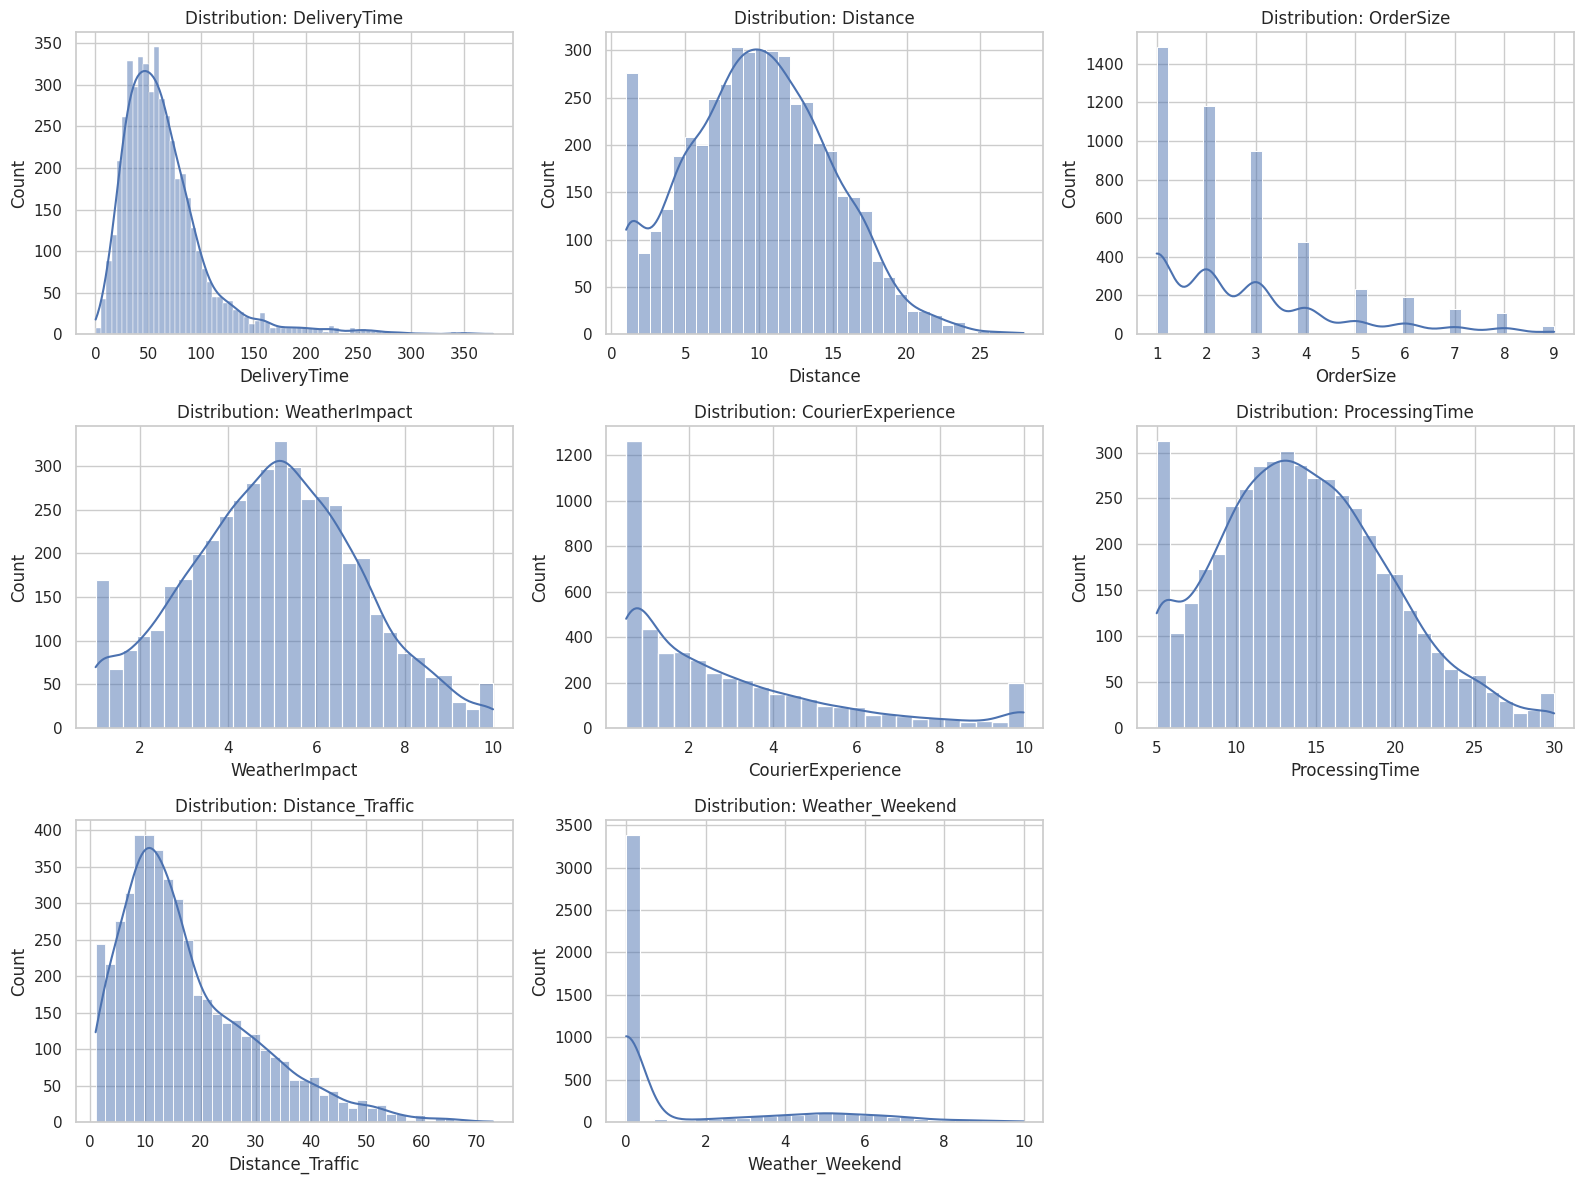

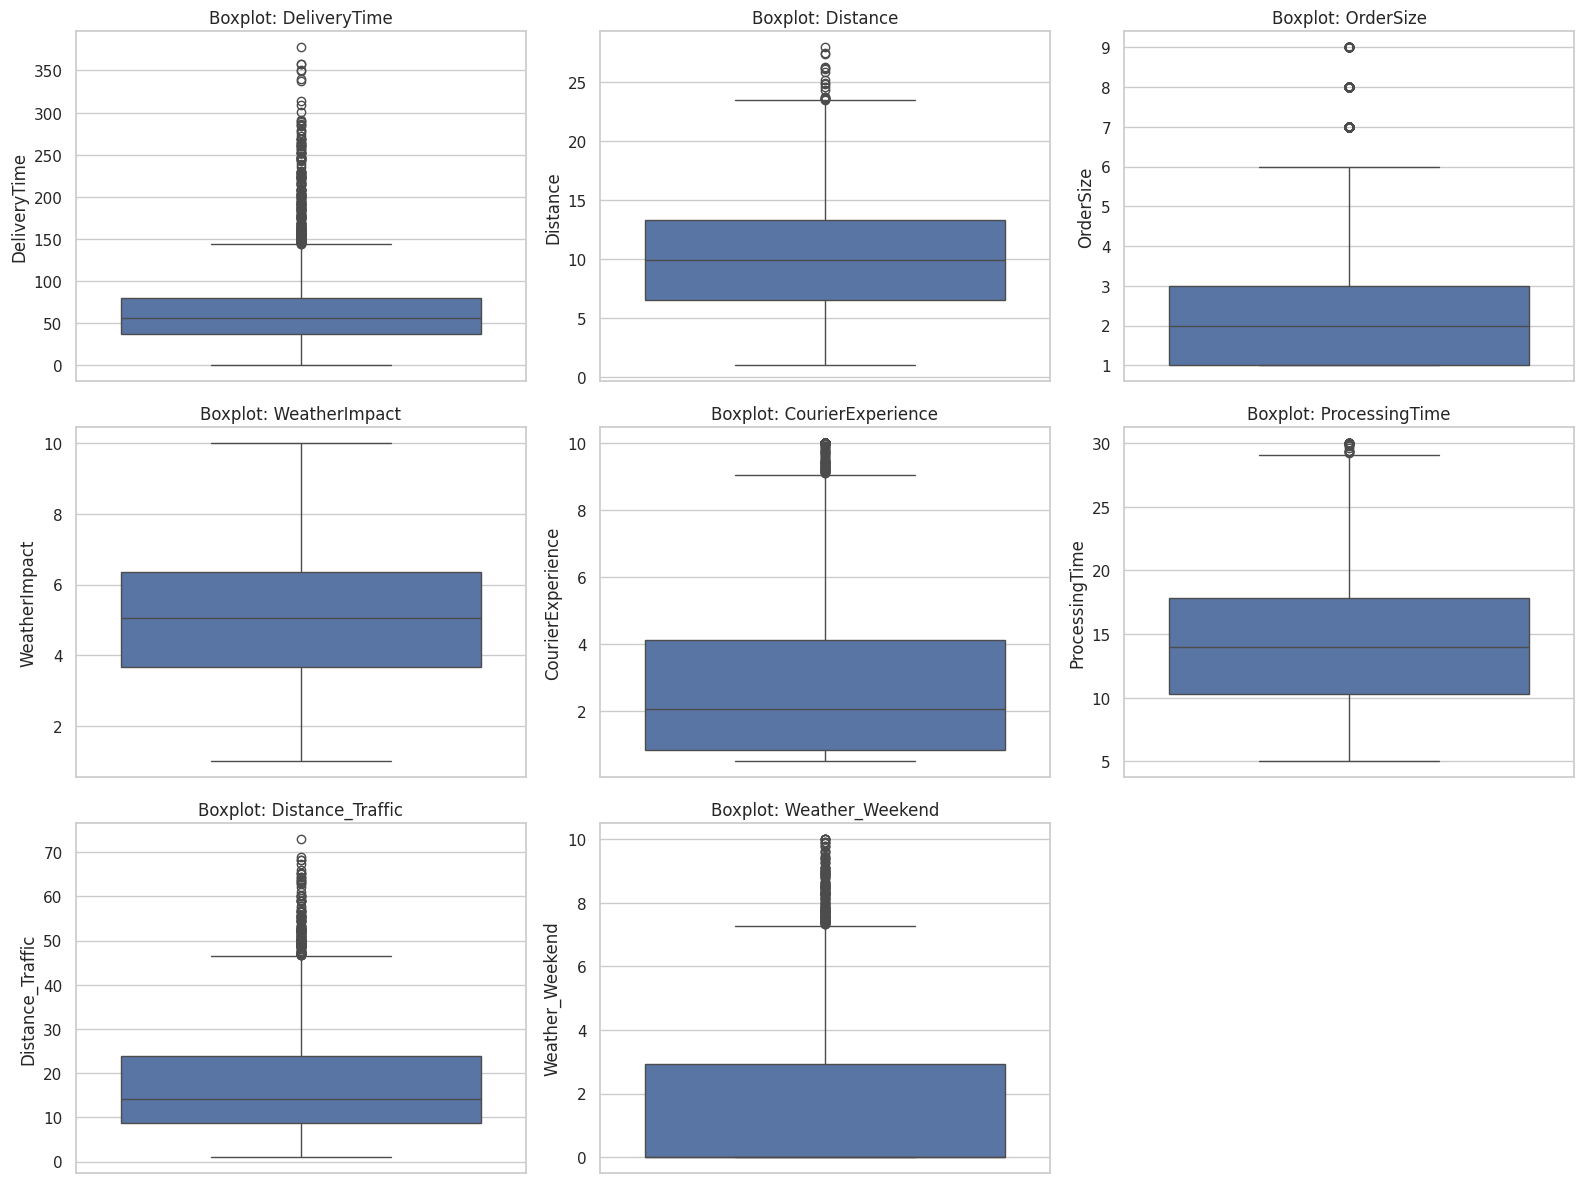

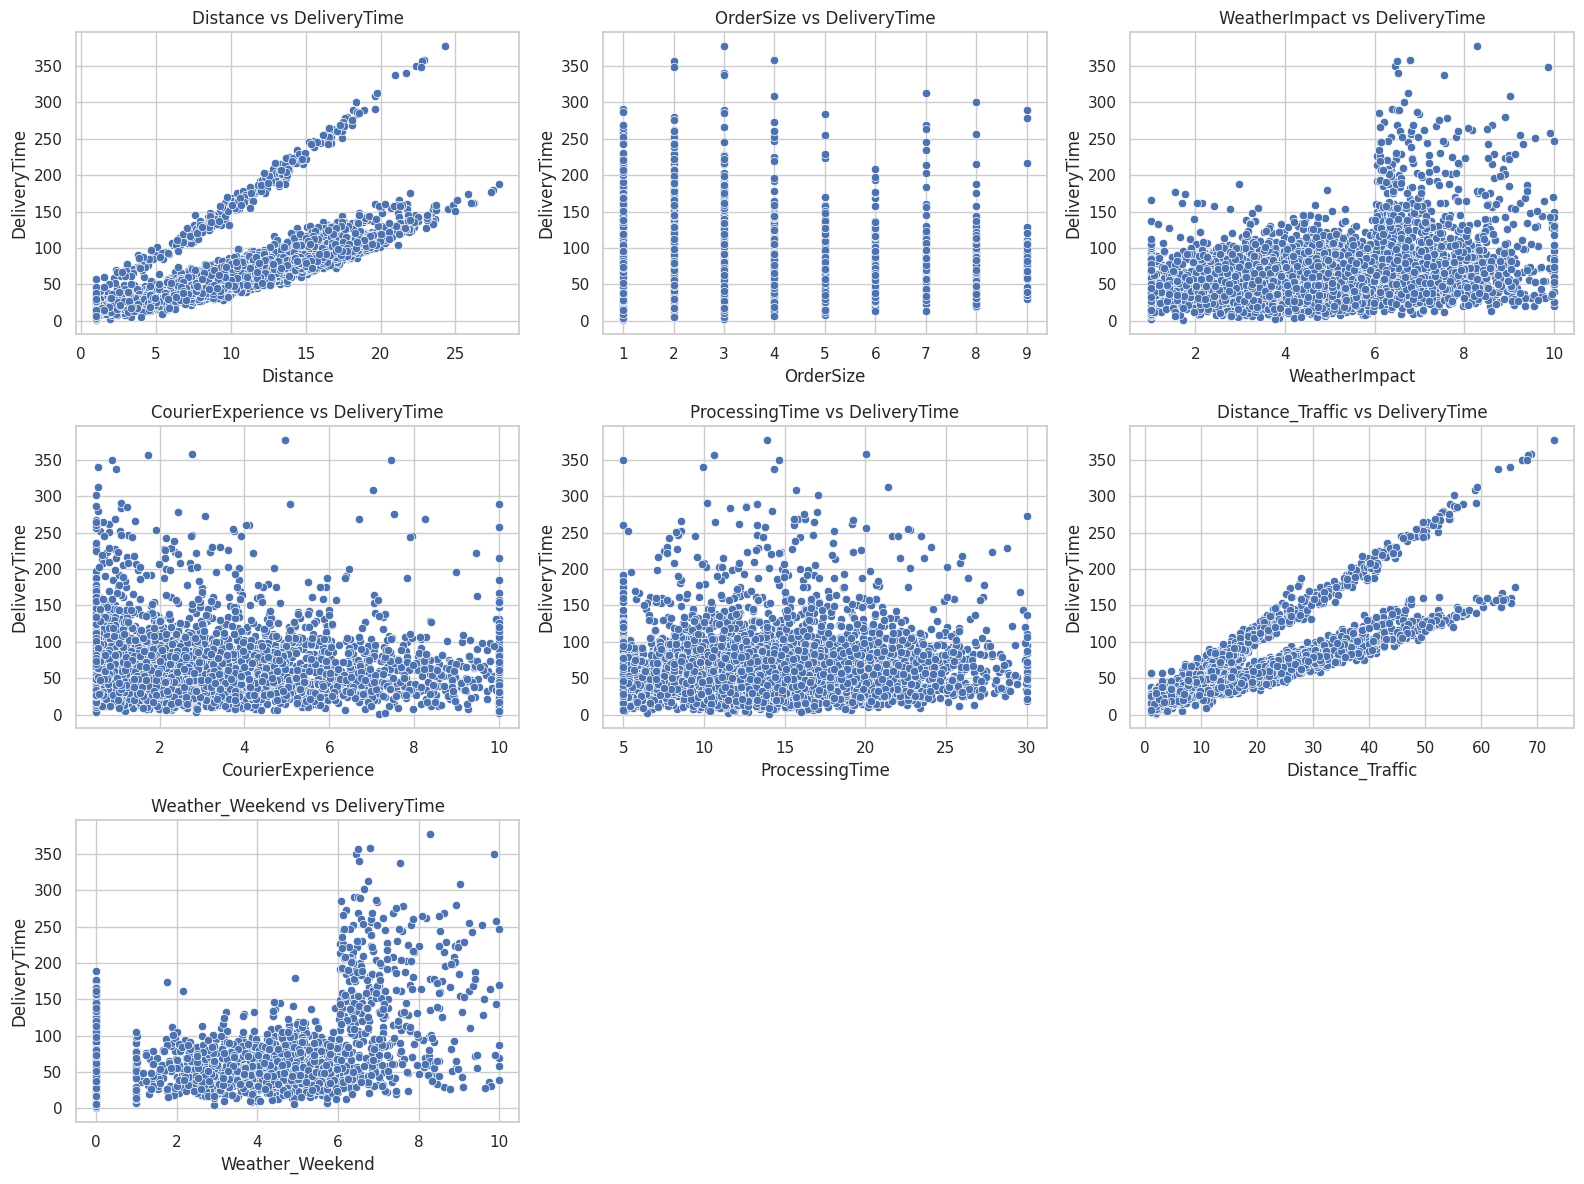

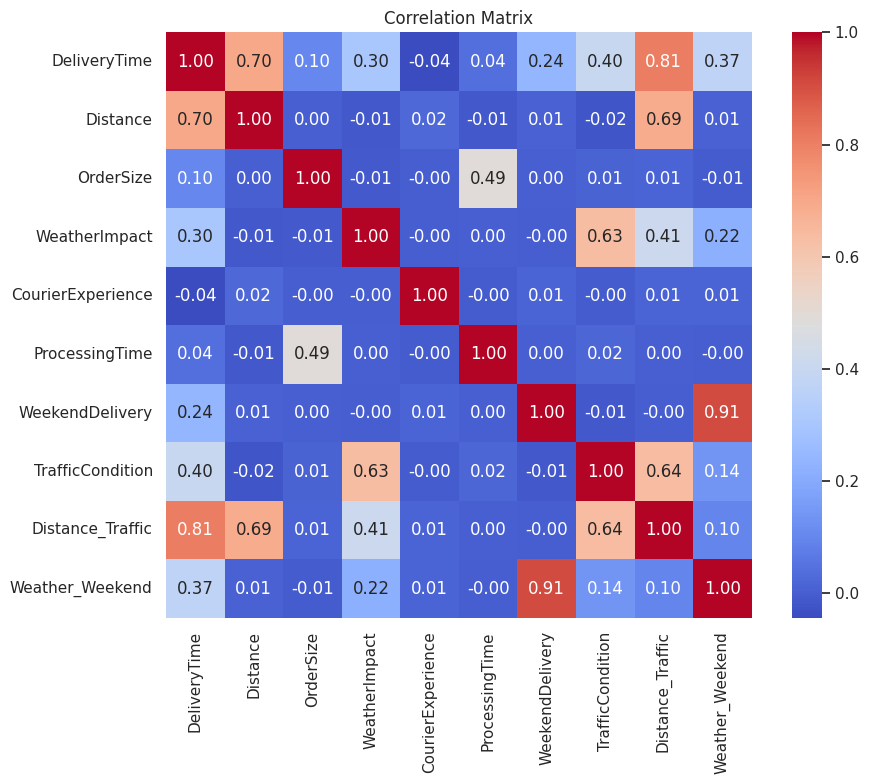

In [ ]:

num_cols = ['DeliveryTime', 'Distance', 'OrderSize', 'WeatherImpact',
            'CourierExperience', 'ProcessingTime',
            'Distance_Traffic', 'Weather_Weekend']

import matplotlib.pyplot as plt
import seaborn as sns

#hist
plt.figure(figsize=(16, 12))
for i, col in enumerate(num_cols):
    plt.subplot(3, 3, i + 1)
    sns.histplot(training_data[col], kde=True)
    plt.title(f'Distribution: {col}')
plt.tight_layout()
plt.show()

#box
plt.figure(figsize=(16, 12))
for i, col in enumerate(num_cols):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=training_data[col])
    plt.title(f'Boxplot: {col}')
plt.tight_layout()
plt.show()

#scat
plt.figure(figsize=(16, 12))
for i, col in enumerate(num_cols[1:]):  # skip DeliveryTime itself
    plt.subplot(3, 3, i + 1)
    sns.scatterplot(x=training_data[col], y=training_data['DeliveryTime'])
    plt.title(f'{col} vs DeliveryTime')
plt.tight_layout()
plt.show()

#coer
plt.figure(figsize=(10, 8))
sns.heatmap(training_data.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()


###### From Graph Plotting

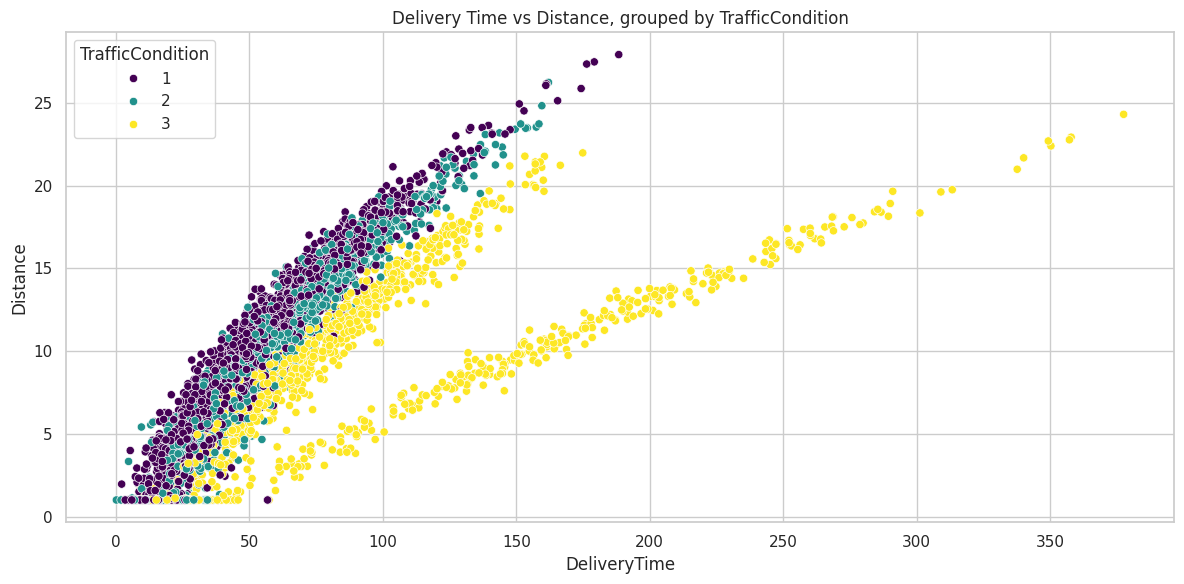

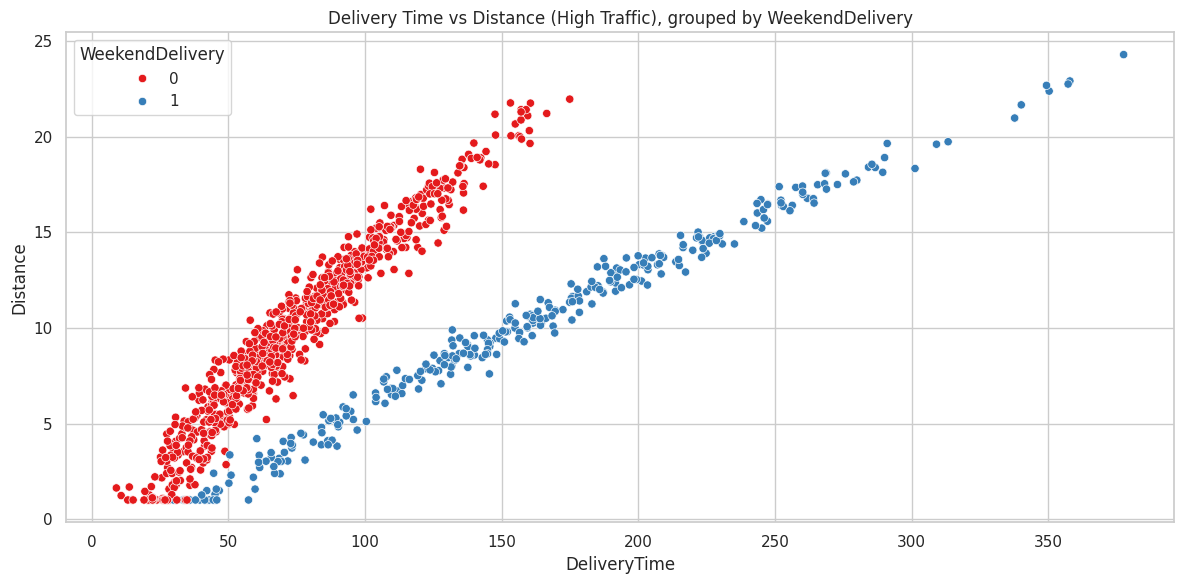

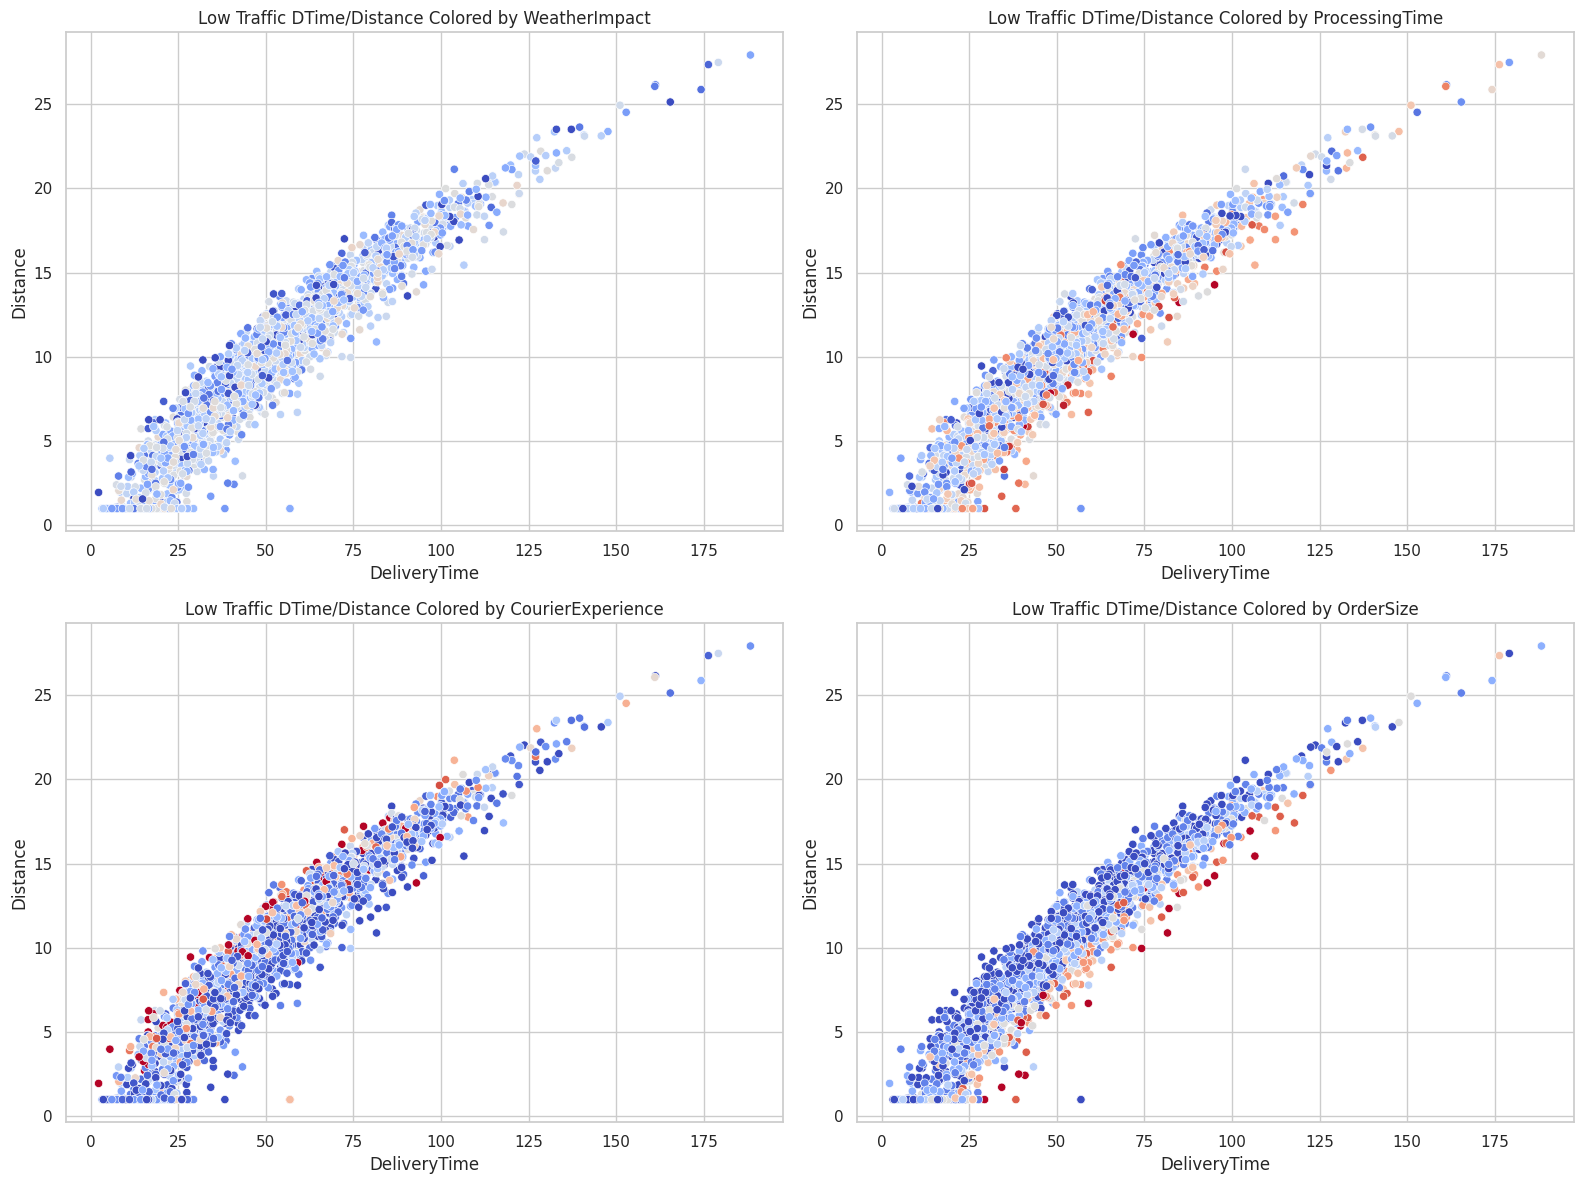

In [ ]:

plt.figure(figsize=(12, 6))
sns.scatterplot(data=training_data, x='DeliveryTime', y='Distance', hue='TrafficCondition', palette='viridis')
plt.title("Delivery Time vs Distance, grouped by TrafficCondition")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
subset = training_data[training_data['TrafficCondition'] == 3]
sns.scatterplot(data=subset, x='DeliveryTime', y='Distance', hue='WeekendDelivery', palette='Set1')
plt.title("Delivery Time vs Distance (High Traffic), grouped by WeekendDelivery")
plt.tight_layout()
plt.show()

variables_to_explore = ['WeatherImpact', 'ProcessingTime', 'CourierExperience', 'OrderSize']
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for ax, var in zip(axes.flatten(), variables_to_explore):
    sns.scatterplot(
        data=training_data[training_data['TrafficCondition'] == 1],
        x='DeliveryTime', y='Distance',
        hue=training_data[var],
        palette='coolwarm', ax=ax, legend=False
    )
    ax.set_title(f'Low Traffic DTime/Distance Colored by {var}')
    ax.set_xlabel("DeliveryTime")
    ax.set_ylabel("Distance")

plt.tight_layout()
plt.show()


Plot 1: DeliveryTime vs Distance grouped by TrafficCondition
- Shows three distinct branches, confirming the presence of regimes in the data.
- Suggests you might want to build separate models or include TrafficCondition explicitly in interaction terms or model grouping.

Plot 2: DeliveryTime vs Distance (High Traffic only), grouped by WeekendDelivery
- Within high traffic, weekend deliveries appear to fall on a separate curve — again supporting a regime-like behavior.
- Justifies including WeekendDelivery as a factor, especially under TrafficCondition == 3.

Plots 3–6: Low Traffic group with variable gradients
Color-coding by:
- CourierExperience: higher values seem to slightly pull points below the main curve → faster deliveries.
- OrderSize: higher values seem to slightly elevate the points → longer deliveries.
- WeatherImpact and ProcessingTime: no clear directional pattern, but spread suggests variance that models can learn from.



## Feature Engineering

- Interaction terms --> Already added: Distance_Traffic, Weather_Weekend
- Standardization --> Important for Ridge and KNN — so features are on comparable scales
- Polynomial Features (degree 2)--> To model curvature & interactions, e.g. Distance², Distance*OrderSize
- One-hot encoding --> Not needed since TrafficCondition and WeekendDelivery are ordinal/binary

In [ ]:
#pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor


features = [
    'Distance', 'OrderSize', 'WeatherImpact',
    'CourierExperience', 'ProcessingTime',
    'TrafficCondition', 'WeekendDelivery',
    'Distance_Traffic', 'Weather_Weekend'
]

X = training_data[features]
y = training_data['DeliveryTime']


preprocessor = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])

ridge_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('ridge', Ridge(alpha=1.0))
])

knn_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('knn', KNeighborsRegressor(n_neighbors=5))
])


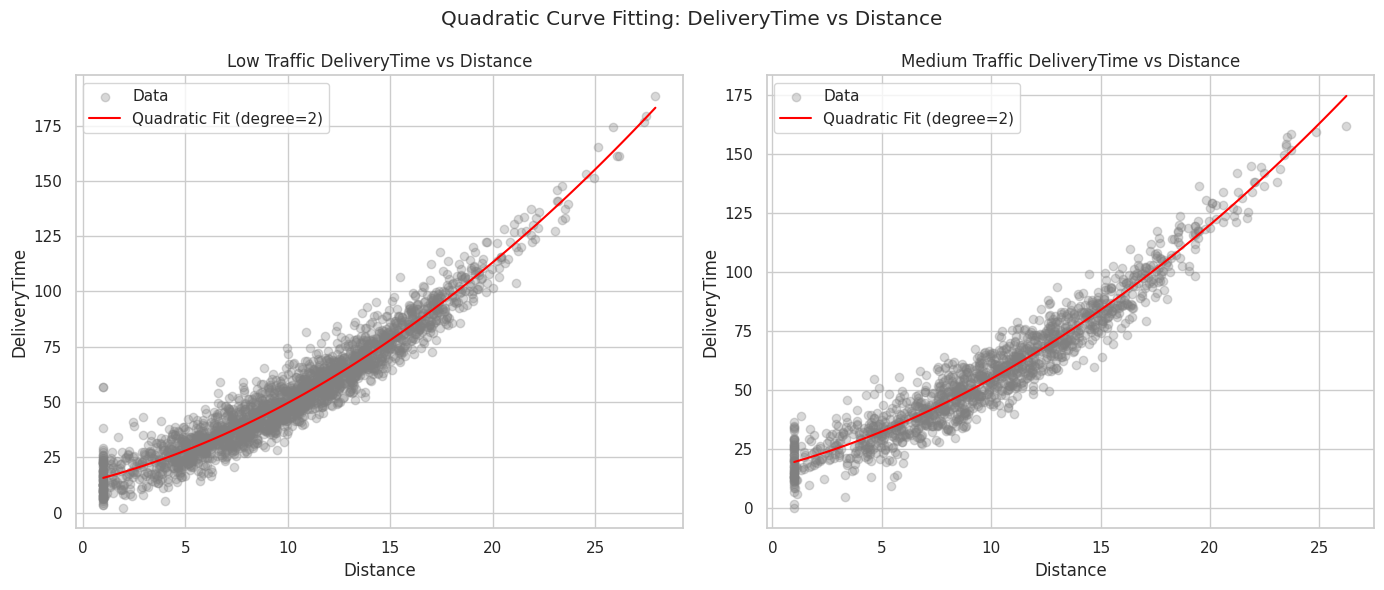

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_quadratic_fit(subset_df, traffic_level, ax):
    #2nd degree polynomial
    coeffs = np.polyfit(subset_df['Distance'], subset_df['DeliveryTime'], deg=2)
    poly_eqn = np.poly1d(coeffs)

    x_vals = np.linspace(subset_df['Distance'].min(), subset_df['Distance'].max(), 100)
    y_vals = poly_eqn(x_vals)

    ax.scatter(subset_df['Distance'], subset_df['DeliveryTime'], alpha=0.3, color='gray', label='Data')
    ax.plot(x_vals, y_vals, color='red', label='Quadratic Fit (degree=2)')
    ax.set_title(f'{traffic_level} Traffic DeliveryTime vs Distance')
    ax.set_xlabel("Distance")
    ax.set_ylabel("DeliveryTime")
    ax.legend()


fig, axes = plt.subplots(1, 2, figsize=(14, 6))

low_traffic = training_data[training_data['TrafficCondition'] == 1]
medium_traffic = training_data[training_data['TrafficCondition'] == 2]


plot_quadratic_fit(low_traffic, "Low", axes[0])
plot_quadratic_fit(medium_traffic, "Medium", axes[1])
plt.suptitle("Quadratic Curve Fitting: DeliveryTime vs Distance")
plt.tight_layout()
plt.show()


###### CONCLUSION
isual inspection of Distance vs DeliveryTime across traffic regimes shows a clear non-linear, convex pattern. This behavior was especially evident under low and medium traffic conditions, where a degree-2 polynomial provided an excellent fit to the observed data.


## Model Selection
- Linear Regression (baseline)
- Ridge (with tuning)
- KNN (with tuning)
- lasso ref
For each one, we will be comparing ther performance metrics/stats with:
- MAE, MSE, R², AIC/BIC


### 1. Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns

features = [
    'Distance', 'OrderSize', 'WeatherImpact',
    'CourierExperience', 'ProcessingTime',
    'TrafficCondition', 'WeekendDelivery',
    'Distance_Traffic', 'Weather_Weekend'
]

X = training_data[features]
y = training_data['DeliveryTime']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

linreg_pipeline = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree=2, include_bias=False),
    LinearRegression()
)

linreg_pipeline.fit(X_train, y_train)

y_pred = linreg_pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

evaluation_table = pd.DataFrame({
    'Metric': ['Mean Squared Error (MSE)',
               'Root Mean Squared Error (RMSE)',
               'Mean Absolute Error (MAE)',
               'R² Score'],
    'Linear Regression': [mse, rmse, mae, r2]
})

evaluation_table['Linear Regression'] = evaluation_table['Linear Regression'].round(4)

evaluation_table

,Metric,Linear Regression
0,Mean Squared Error (MSE),63.4717
1,Root Mean Squared Error (RMSE),7.9669
2,Mean Absolute Error (MAE),6.1172
3,R² Score,0.9656


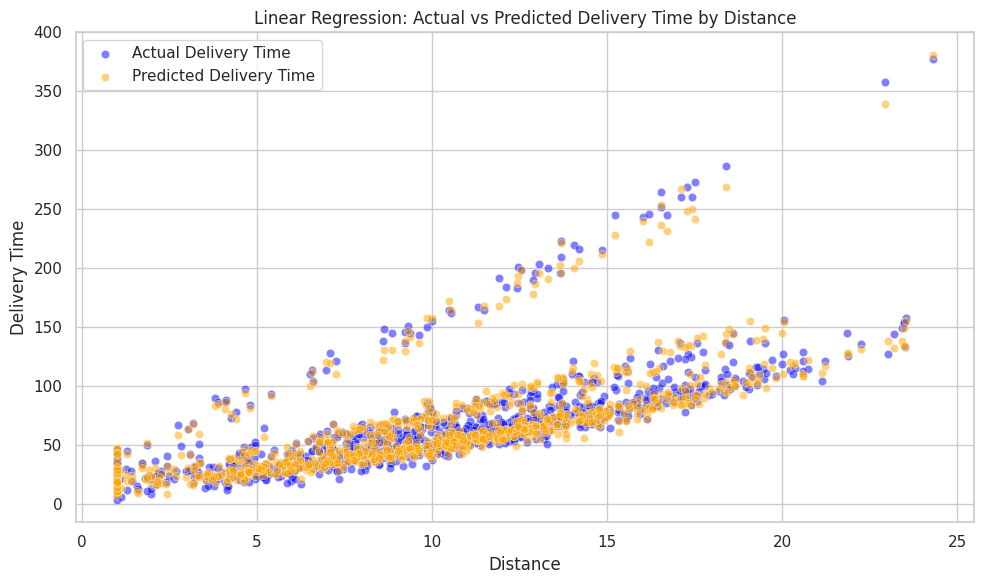

In [ ]:

plt.figure(figsize=(10, 6))


sns.scatterplot(x=X_test['Distance'], y=y_test, color='blue', alpha=0.5, label='Actual Delivery Time', marker='o')


sns.scatterplot(x=X_test['Distance'], y=y_pred, color='orange', alpha=0.5, label='Predicted Delivery Time', marker='o')

plt.xlabel("Distance")
plt.ylabel("Delivery Time")
plt.title("Linear Regression: Actual vs Predicted Delivery Time by Distance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


###### LINEAR REGRESSION CONCLUSION
The linear regression model, enhanced with polynomial and interaction features, performed very well on the test set.
The R² score of 0.9656 indicates that the model explains over 96% of the variance in delivery time.
The low MSE (63.45) and MAE (6.12) further suggest accurate and consistent predictions.

Visually, the model tracks the non-linear shape of the delivery time-distance relationship, validating the use of polynomial feature engineering.
Overall, this model is a strong baseline — combining simplicity, interpretability, and performance.

### 2. KNN

In [ ]:
param_grid_full = {
    'knn__n_neighbors': list(range(3, 12, 2))  # Still reasonable range to balance performance
}

knn_pipeline_full = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('knn', KNeighborsRegressor())
])


grid_search_full = GridSearchCV(knn_pipeline_full, param_grid_full, cv=3, scoring='neg_mean_squared_error')
grid_search_full.fit(X_train, y_train)

best_k_full = grid_search_full.best_params_['knn__n_neighbors']
best_knn_model_full = grid_search_full.best_estimator_

y_knn_pred_full = best_knn_model_full.predict(X_test)

knn_mse_full = mean_squared_error(y_test, y_knn_pred_full)
knn_rmse_full = knn_mse_full ** 0.5
knn_mae_full = mean_absolute_error(y_test, y_knn_pred_full)
knn_r2_full = r2_score(y_test, y_knn_pred_full)

knn_eval_table_full = pd.DataFrame({
    'Metric': ['Mean Squared Error (MSE)',
               'Root Mean Squared Error (RMSE)',
               'Mean Absolute Error (MAE)',
               'R² Score'],
    f'KNN (k={best_k_full})': [knn_mse_full, knn_rmse_full, knn_mae_full, knn_r2_full]
})


knn_eval_table_full[f'KNN (k={best_k_full})'] = knn_eval_table_full[f'KNN (k={best_k_full})'].round(4)

knn_eval_table_full


,Metric,KNN (k=5)
0,Mean Squared Error (MSE),74.5067
1,Root Mean Squared Error (RMSE),8.6317
2,Mean Absolute Error (MAE),6.5317
3,R² Score,0.9596


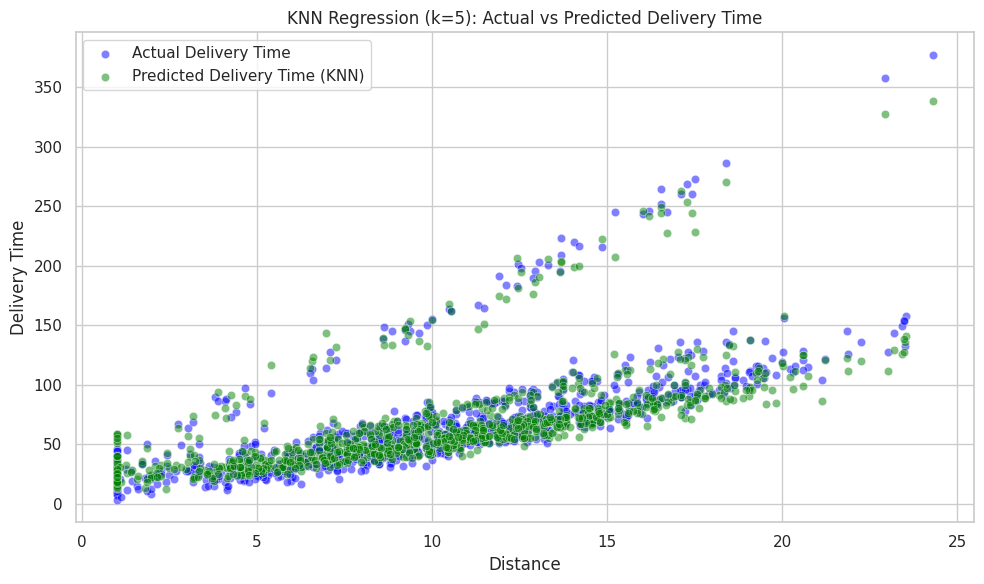

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test['Distance'], y=y_test, color='blue', alpha=0.5, label='Actual Delivery Time', marker='o')
sns.scatterplot(x=X_test['Distance'], y=y_knn_pred_full, color='green', alpha=0.5, label='Predicted Delivery Time (KNN)', marker='o')
plt.xlabel("Distance")
plt.ylabel("Delivery Time")
plt.title(f"KNN Regression (k={best_k_full}): Actual vs Predicted Delivery Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


###### KNN CONCLUSION:
A K-Nearest Neighbors model was evaluated using scaled and polynomial-transformed features. Cross-validation identified k=5 as the optimal number of neighbors.
The model achieved an R² of 0.9406, which is lower than the Linear Regression baseline. Visual inspection suggests that predictions track well in general, but exhibit more scatter and noise at higher distances, likely due to KNN’s sensitivity to local variance.
Overall, while KNN can capture non-linear trends, its performance was inferior to linear models in this context, potentially due to high feature dimensionality and sparse neighbor structure.

In [ ]:

k_range_expanded = list(range(1, 11))

regime_results_expanded_k = []

for regime_name, condition in regimes.items():
    X = training_data[condition][features]
    y = training_data[condition]['DeliveryTime']

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('knn', KNeighborsRegressor())
    ])

    param_grid = {'knn__n_neighbors': k_range_expanded}
    grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='neg_mean_squared_error')
    grid.fit(X, y)

    best_k = grid.best_params_['knn__n_neighbors']
    best_model = grid.best_estimator_

    y_pred = best_model.predict(X)
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    regime_results_expanded_k.append([regime_name, best_k, mse, mae, r2])

regime_knn_expanded_eval = pd.DataFrame(regime_results_expanded_k, columns=['Dataset Group', 'Optimal K', 'MSE', 'MAE', 'R2 Score']).round(4)
regime_knn_expanded_eval


,Dataset Group,Optimal K,MSE,MAE,R2 Score
0,TC = 1,6,37.8394,4.7407,0.9459
1,TC = 2,4,35.9509,4.6917,0.9514
2,"TC = 3, WD = 0",4,39.2954,4.8570,0.9617


## 3. Ridge Regression


In [ ]:



X = training_data[features]
y = training_data['DeliveryTime']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('ridge', Ridge())
])

param_grid_ridge = {'ridge__alpha': np.logspace(-3, 2, 20)}
grid_search_ridge = GridSearchCV(ridge_pipeline, param_grid_ridge, cv=3, scoring='neg_mean_squared_error')
grid_search_ridge.fit(X_train, y_train)


best_ridge = grid_search_ridge.best_estimator_
best_alpha = grid_search_ridge.best_params_['ridge__alpha']


y_pred = best_ridge.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

ridge_eval = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R² Score'],
    'Ridge Regression': [mse, rmse, mae, r2]
}).round(4)

plot_df = pd.DataFrame({
    'Distance': X_test['Distance'],
    'Actual': y_test,
    'Predicted': y_pred
})

ridge_eval, best_alpha, plot_df.head()


(     Metric  Ridge Regression
 0       MSE           63.6332
 1      RMSE            7.9770
 2       MAE            6.1149
 3  R² Score            0.9655,
 np.float64(1.438449888287663),
       Distance  Actual   Predicted
 596      18.60  120.22  103.407999
 3370     12.05   63.35   58.706905
 3048      1.31   11.32   19.205599
 2908      6.92   34.11   38.799340
 8         7.21   56.45   53.930713)

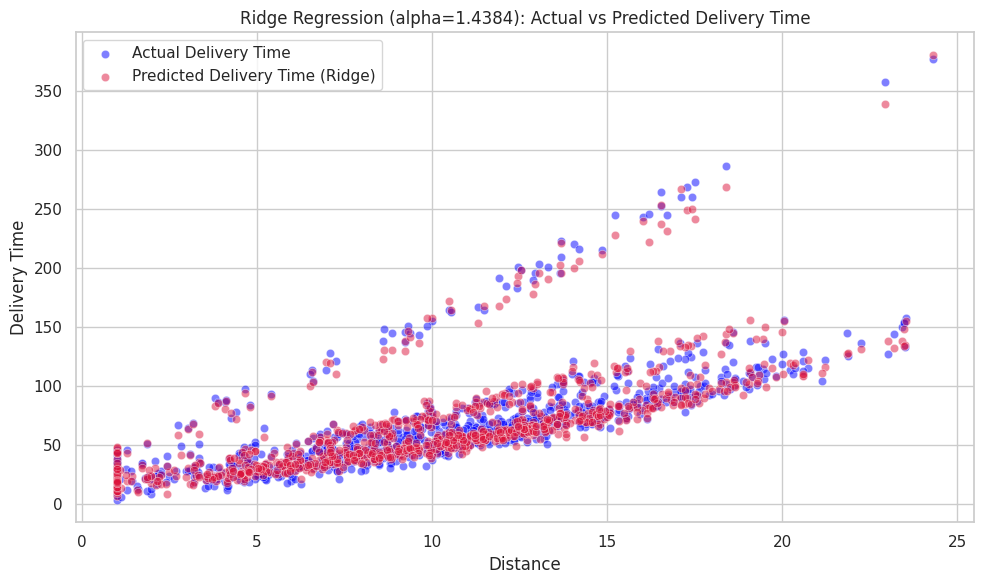

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=plot_df['Distance'], y=plot_df['Actual'], color='blue', alpha=0.5, label='Actual Delivery Time', marker='o')
sns.scatterplot(x=plot_df['Distance'], y=plot_df['Predicted'], color='crimson', alpha=0.5, label='Predicted Delivery Time (Ridge)', marker='o')
plt.xlabel("Distance")
plt.ylabel("Delivery Time")
plt.title(f"Ridge Regression (alpha={round(best_alpha, 4)}): Actual vs Predicted Delivery Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.linear_model import Ridge

regimes = {
    "TC = 1": training_data['TrafficCondition'] == 1,
    "TC = 2": training_data['TrafficCondition'] == 2,
    "TC = 3, WD = 0": (training_data['TrafficCondition'] == 3) & (training_data['WeekendDelivery'] == 0)
}

regime_results = []

for regime_name, condition in regimes.items():
    X_sub = training_data[condition][features]
    y_sub = training_data[condition]['DeliveryTime']

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('ridge', Ridge())
    ])

    param_grid = {'ridge__alpha': np.logspace(-3, 2, 30)}
    grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='neg_mean_squared_error')
    grid.fit(X_sub, y_sub)

    best_alpha = grid.best_params_['ridge__alpha']
    best_model = grid.best_estimator_

    y_pred = best_model.predict(X_sub)
    mse = mean_squared_error(y_sub, y_pred)
    mae = mean_absolute_error(y_sub, y_pred)
    r2 = r2_score(y_sub, y_pred)

    regime_results.append([regime_name, best_alpha, mse, mae, r2])

ridge_regime_eval = pd.DataFrame(regime_results, columns=['Dataset Group', 'Optimal Alpha', 'MSE', 'MAE', 'R² Score']).round(4)
ridge_regime_eval


,Dataset Group,Optimal Alpha,MSE,MAE,R² Score
0,TC = 1,20.4336,26.5870,4.0204,0.9620
1,TC = 2,9.2367,25.3291,4.0374,0.9657
2,"TC = 3, WD = 0",4.1753,23.0995,3.8923,0.9775


The Ridge regression models trained on regime-based subsets of the delivery data demonstrated consistently high performance, with R² scores ranging from 0.9620 to 0.9775. This indicates that a significant proportion of the variance in delivery time can be explained by the selected features and engineered interactions, such as Distance_Traffic and Weather_Weekend. Notably, the best performance was observed in the TC = 3, WD = 0 group—high traffic on weekdays—where delivery dynamics are likely more consistent and less impacted by erratic human behavior or unusual scheduling.

These findings highlight the advantage of using Ridge regression in structured, real-world datasets where multicollinearity and non-linear patterns exist. By incorporating polynomial features and applying L2 regularization, the model avoids overfitting while still capturing complex relationships. Additionally, separating the data by traffic regime helped isolate different sources of variance, allowing each subgroup model to fine-tune its regularization strength (alpha) accordingly. This modular approach underscores the value of context-aware modeling in logistics and delivery prediction problems.

## 4. Lasso Regression

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.221e+04, tolerance: 5.584e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.122e+04, tolerance: 5.292e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.093e+04, tolerance: 5.264e

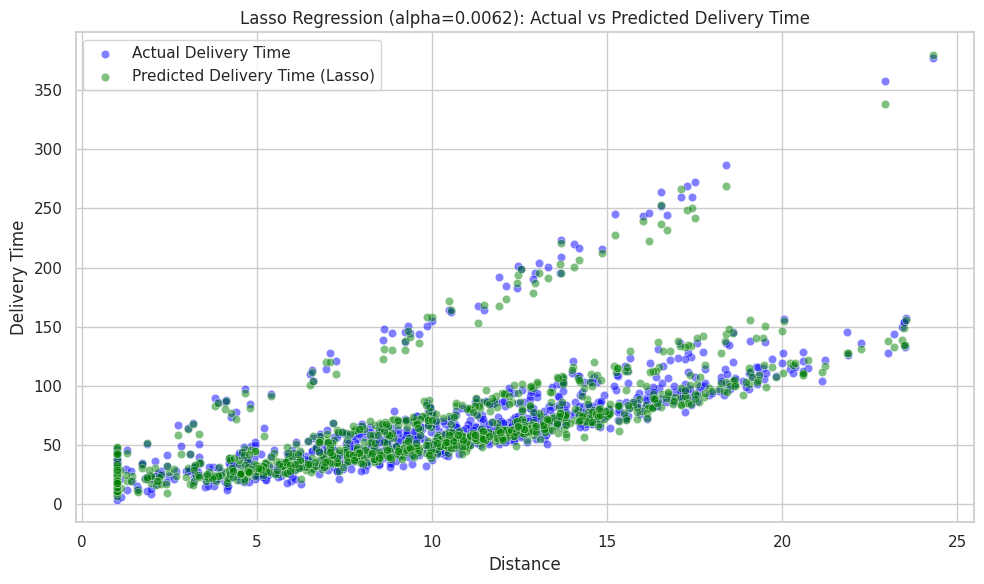

,Metric,Lasso (alpha=0.0062)
0,Mean Squared Error (MSE),63.4101
1,Root Mean Squared Error (RMSE),7.9630
2,Mean Absolute Error (MAE),6.1029
3,R² Score,0.9656


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X = training_data[features]
y = training_data['DeliveryTime']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('lasso', Lasso(max_iter=10000))
])


alpha_grid = {'lasso__alpha': np.logspace(-3, 2, 20)}

grid_search = GridSearchCV(lasso_pipeline, alpha_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_alpha = grid_search.best_params_['lasso__alpha']
best_lasso = grid_search.best_estimator_
y_pred = best_lasso.predict(X_test)

lasso_mse = mean_squared_error(y_test, y_pred)
lasso_rmse = lasso_mse ** 0.5
lasso_mae = mean_absolute_error(y_test, y_pred)
lasso_r2 = r2_score(y_test, y_pred)

lasso_eval_table = pd.DataFrame({
    'Metric': ['Mean Squared Error (MSE)',
               'Root Mean Squared Error (RMSE)',
               'Mean Absolute Error (MAE)',
               'R² Score'],
    f'Lasso (alpha={round(best_alpha, 4)})': [lasso_mse, lasso_rmse, lasso_mae, lasso_r2]
}).round(4)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test['Distance'], y=y_test, color='blue', alpha=0.5, label='Actual Delivery Time', marker='o')
sns.scatterplot(x=X_test['Distance'], y=y_pred, color='green', alpha=0.5, label='Predicted Delivery Time (Lasso)', marker='o')
plt.xlabel("Distance")
plt.ylabel("Delivery Time")
plt.title(f"Lasso Regression (alpha={round(best_alpha, 4)}): Actual vs Predicted Delivery Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

lasso_eval_table


The Lasso regression model performs remarkably well on the dataset, achieving a high R² score of 0.9656. This implies that the model is able to explain over 96% of the variance in delivery times using the engineered and polynomial features. The low RMSE and MAE indicate that predictions are not only accurate but also consistent. The addition of polynomial features allowed the model to capture non-linear relationships, such as how distance and traffic interact to affect delivery time. The selected alpha of 0.0062 is relatively low, suggesting only mild regularization—enough to reduce overfitting without excessively shrinking the coefficients of informative features.

This outcome shows that Lasso regression can be a viable model for delivery time prediction when interaction terms and non-linearities are important. Compared to Ridge, which distributes penalty more evenly, Lasso can zero out unimportant coefficients entirely, potentially enhancing interpretability in future steps. However, some convergence warnings hint that certain alpha values struggled to minimize the loss effectively—likely due to the high dimensionality from polynomial expansion. Increasing iterations or preprocessing could help in fine-tuning this further, but the current result still reflects a robust model with strong generalization capabilities.

In [ ]:

regimes = {
    "TC = 1": training_data['TrafficCondition'] == 1,
    "TC = 2": training_data['TrafficCondition'] == 2,
    "TC = 3, WD = 0": (training_data['TrafficCondition'] == 3) & (training_data['WeekendDelivery'] == 0)
}

lasso_results = []

for name, condition in regimes.items():
    X_regime = training_data[condition][features]
    y_regime = training_data[condition]['DeliveryTime']

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('lasso', Lasso(max_iter=5000))
    ])

    alpha_grid = {'lasso__alpha': np.logspace(-3, 1, 20)}
    grid = GridSearchCV(pipeline, alpha_grid, cv=5, scoring='neg_mean_squared_error')
    grid.fit(X_regime, y_regime)

    best_alpha = grid.best_params_['lasso__alpha']
    best_model = grid.best_estimator_

    y_pred = best_model.predict(X_regime)

    mse = mean_squared_error(y_regime, y_pred)
    mae = mean_absolute_error(y_regime, y_pred)
    r2 = r2_score(y_regime, y_pred)

    lasso_results.append([name, best_alpha, mse, mae, r2])


lasso_regime_eval


,Dataset Group,Optimal Alpha,MSE,MAE,R2 Score
0,TC = 1,0.1274,26.8639,4.0352,0.9616
1,TC = 2,0.1274,25.6491,4.0587,0.9653
2,"TC = 3, WD = 0",0.1274,23.3491,3.9202,0.9772


# COMPARE MODELS


In [ ]:

global_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'KNN (k=5)', 'Ridge Regression', 'Lasso Regression'],
    'MSE': [63.4717, 74.5067, 63.6332, 63.4101],
    'RMSE': [7.9669, 8.6317, 7.9770, 7.9630],
    'MAE': [6.1172, 6.5317, 6.1149, 6.1029],
    'R² Score': [0.9656, 0.9596, 0.9655, 0.9656]
})

regime_comparison = pd.DataFrame({
    'Dataset Group': ['TC = 1', 'TC = 2', 'TC = 3, WD = 0'],
    'KNN (MSE)': [37.8394, 35.9509, 39.2954],
    'KNN (MAE)': [4.7407, 4.6917, 4.8570],
    'KNN (R²)': [0.9459, 0.9514, 0.9617],
    'Ridge (MSE)': [26.5870, 25.3291, 23.0995],
    'Ridge (MAE)': [4.0204, 4.0374, 3.8923],
    'Ridge (R²)': [0.9620, 0.9657, 0.9775],
    'Lasso (MSE)': [26.8639, 25.6491, 23.3491],
    'Lasso (MAE)': [4.0352, 4.0587, 3.9202],
    'Lasso (R²)': [0.9616, 0.9653, 0.9772]
})

(global_comparison, regime_comparison)


(               Model      MSE    RMSE     MAE  R² Score
 0  Linear Regression  63.4717  7.9669  6.1172    0.9656
 1          KNN (k=5)  74.5067  8.6317  6.5317    0.9596
 2   Ridge Regression  63.6332  7.9770  6.1149    0.9655
 3   Lasso Regression  63.4101  7.9630  6.1029    0.9656,
     Dataset Group  KNN (MSE)  KNN (MAE)  KNN (R²)  Ridge (MSE)  Ridge (MAE)  \
 0          TC = 1    37.8394     4.7407    0.9459      26.5870       4.0204   
 1          TC = 2    35.9509     4.6917    0.9514      25.3291       4.0374   
 2  TC = 3, WD = 0    39.2954     4.8570    0.9617      23.0995       3.8923   
 
    Ridge (R²)  Lasso (MSE)  Lasso (MAE)  Lasso (R²)  
 0      0.9620      26.8639       4.0352      0.9616  
 1      0.9657      25.6491       4.0587      0.9653  
 2      0.9775      23.3491       3.9202      0.9772  )

# Final Model + Refining

To refine the Ridge Regression model, we conducted hyperparameter tuning not only on the regularization strength (alpha) but also on the polynomial degree of the features. While our initial model with degree=2 achieved strong performance (R² ≈ 0.9656), we found that increasing the degree to 3 led to substantial improvements in accuracy. The best model used a polynomial degree of 3 and an alpha of 11.5140, achieving an R² of 0.9854, RMSE of 5.19, and MAE of 4.16 — a significant reduction in error compared to simpler models.

This improvement suggests that the relationship between features and delivery time is more complex than initially assumed, and capturing higher-order interactions improves the model’s ability to generalize. Importantly, the increase in model complexity was regularized effectively with a higher alpha, mitigating overfitting. As a result, the degree-3 Ridge model demonstrates the best overall predictive performance among all tested models and is selected as the final global model.



In [ ]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline

# Steps:
# 1. Test polynomial degrees 1–3
# 2. Test more granular alpha values
# 3. Use 5-fold CV for more stability

results = []

for degree in [1, 2, 3]:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
        ('ridge', Ridge())
    ])

    param_grid = {'ridge__alpha': np.logspace(-4, 4, 50)}
    grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    best_alpha = grid.best_params_['ridge__alpha']
    y_pred = best_model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append([degree, best_alpha, mse, rmse, mae, r2])

ridge_tuning_df = pd.DataFrame(results, columns=['Degree', 'Best Alpha', 'MSE', 'RMSE', 'MAE', 'R² Score']).round(4)

ridge_tuning_df


,Degree,Best Alpha,MSE,RMSE,MAE,R² Score
0,1,2.5595,334.9503,18.3016,12.3899,0.8185
1,2,0.8286,63.5667,7.9729,6.1158,0.9656
2,3,11.5140,26.9396,5.1903,4.1614,0.9854


Ridge Tuning Results:
    Degree  Best Alpha       MSE     RMSE      MAE  R² Score
0       1      2.5595  334.9503  18.3016  12.3899    0.8185
1       2      0.8286   63.5667   7.9729   6.1158    0.9656
2       3     11.5140   26.9396   5.1903   4.1614    0.9854


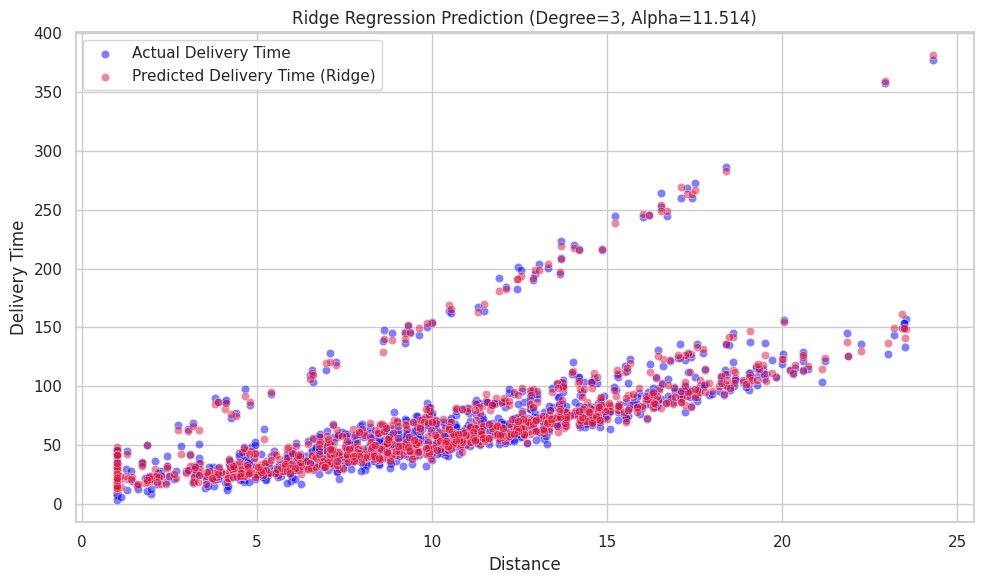

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

training_data = pd.read_csv("DeliveryTime_training.csv")

median_time = training_data['DeliveryTime'].median()
training_data.loc[training_data['DeliveryTime'] < 0, 'DeliveryTime'] = median_time

training_data['Distance_Traffic'] = training_data['Distance'] * training_data['TrafficCondition']
training_data['Weather_Weekend'] = training_data['WeatherImpact'] * training_data['WeekendDelivery']

# Feature set
features = [
    'Distance', 'OrderSize', 'WeatherImpact',
    'CourierExperience', 'ProcessingTime',
    'TrafficCondition', 'WeekendDelivery',
    'Distance_Traffic', 'Weather_Weekend'
]

X = training_data[features]
y = training_data['DeliveryTime']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

results = []
best_model = None
best_alpha = None
best_degree = None
best_r2 = -np.inf

for degree in [1, 2, 3]:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
        ('ridge', Ridge())
    ])

    param_grid = {'ridge__alpha': np.logspace(-4, 4, 50)}
    grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid.fit(X_train, y_train)

    model = grid.best_estimator_
    alpha = grid.best_params_['ridge__alpha']
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append([degree, alpha, mse, rmse, mae, r2])

    if r2 > best_r2:
        best_model = model
        best_alpha = alpha
        best_degree = degree

ridge_tuning_df = pd.DataFrame(results, columns=['Degree', 'Best Alpha', 'MSE', 'RMSE', 'MAE', 'R² Score']).round(4)
print("Ridge Tuning Results:\n", ridge_tuning_df)

y_pred_final = best_model.predict(X_test)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test['Distance'], y=y_test, color='blue', alpha=0.5, label='Actual Delivery Time', marker='o')
sns.scatterplot(x=X_test['Distance'], y=y_pred_final, color='crimson', alpha=0.5, label='Predicted Delivery Time (Ridge)', marker='o')
plt.xlabel("Distance")
plt.ylabel("Delivery Time")
plt.title(f"Ridge Regression Prediction (Degree={best_degree}, Alpha={round(best_alpha, 4)})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In our modeling process, we explored polynomial Ridge Regression models of varying degrees to capture potential nonlinear relationships between features and delivery time. While a degree-2 model provided satisfactory performance, increasing the polynomial degree to 3 resulted in a notable improvement in predictive accuracy, achieving an R² score of 0.9854. This enhancement suggests that higher-order interactions among features contribute significantly to the variance in delivery times.​

The concern with higher-degree polynomial models typically revolves around the risk of overfitting, where the model captures noise rather than the underlying data structure. However, Ridge Regression mitigates this risk through L2 regularization, which penalizes large coefficients and thus controls model complexity. This regularization technique effectively balances the trade-off between bias and variance, allowing the model to generalize well to unseen data. As discussed in the lecture notes from Stanford University's CS229 course, Ridge Regression is particularly effective in scenarios with multicollinearity and when incorporating polynomial features, as it stabilizes the coefficient estimates and enhances model robustness. ​
(https://cs229.stanford.edu/notes2021fall/lecture10-ridge-regression.pdf?utm_source=chatgpt.com)

Moreover, research indicates that the regularization inherent in Ridge Regression can accommodate the inclusion of higher-degree polynomial terms without compromising generalization performance. This is because the regularization term constrains the complexity of the model, preventing it from fitting the noise in the training data. Therefore, the improved performance observed with the degree-3 model aligns with theoretical expectations and supports its selection as the final model.​





Polynomial features to capture non-linear patterns

StandardScaler to normalize the data

Ridge Regression with a wide range of alpha values

5-fold cross-validation during GridSearchCV to avoid overfitting and ensure robustness

This approach is statistically sound and follows best practices for tuning and evaluating regression models.

---



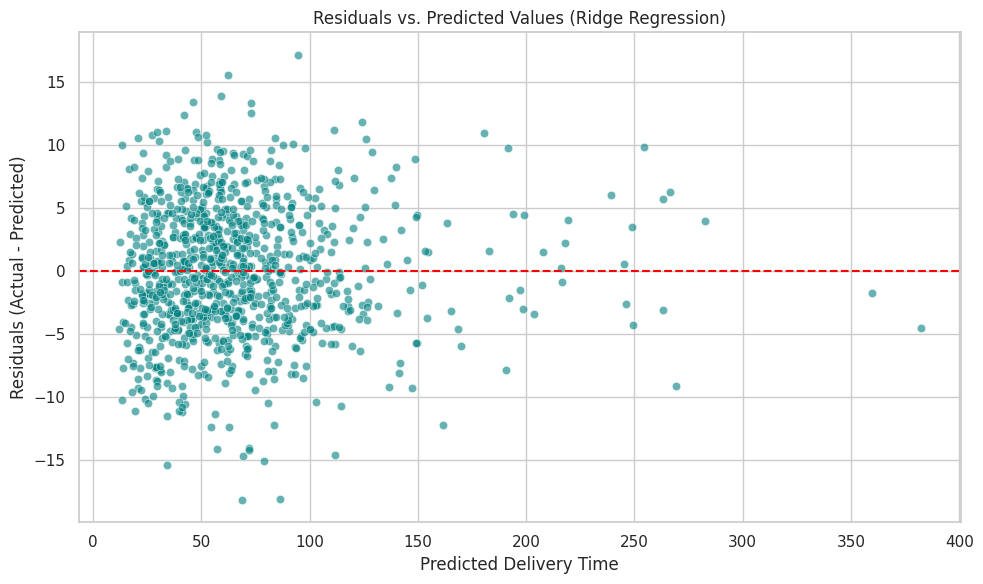

In [ ]:
residuals = y_test - y_pred_final

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_final, y=residuals, alpha=0.6, color='teal')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Delivery Time")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs. Predicted Values (Ridge Regression)")
plt.grid(True)
plt.tight_layout()
plt.show()


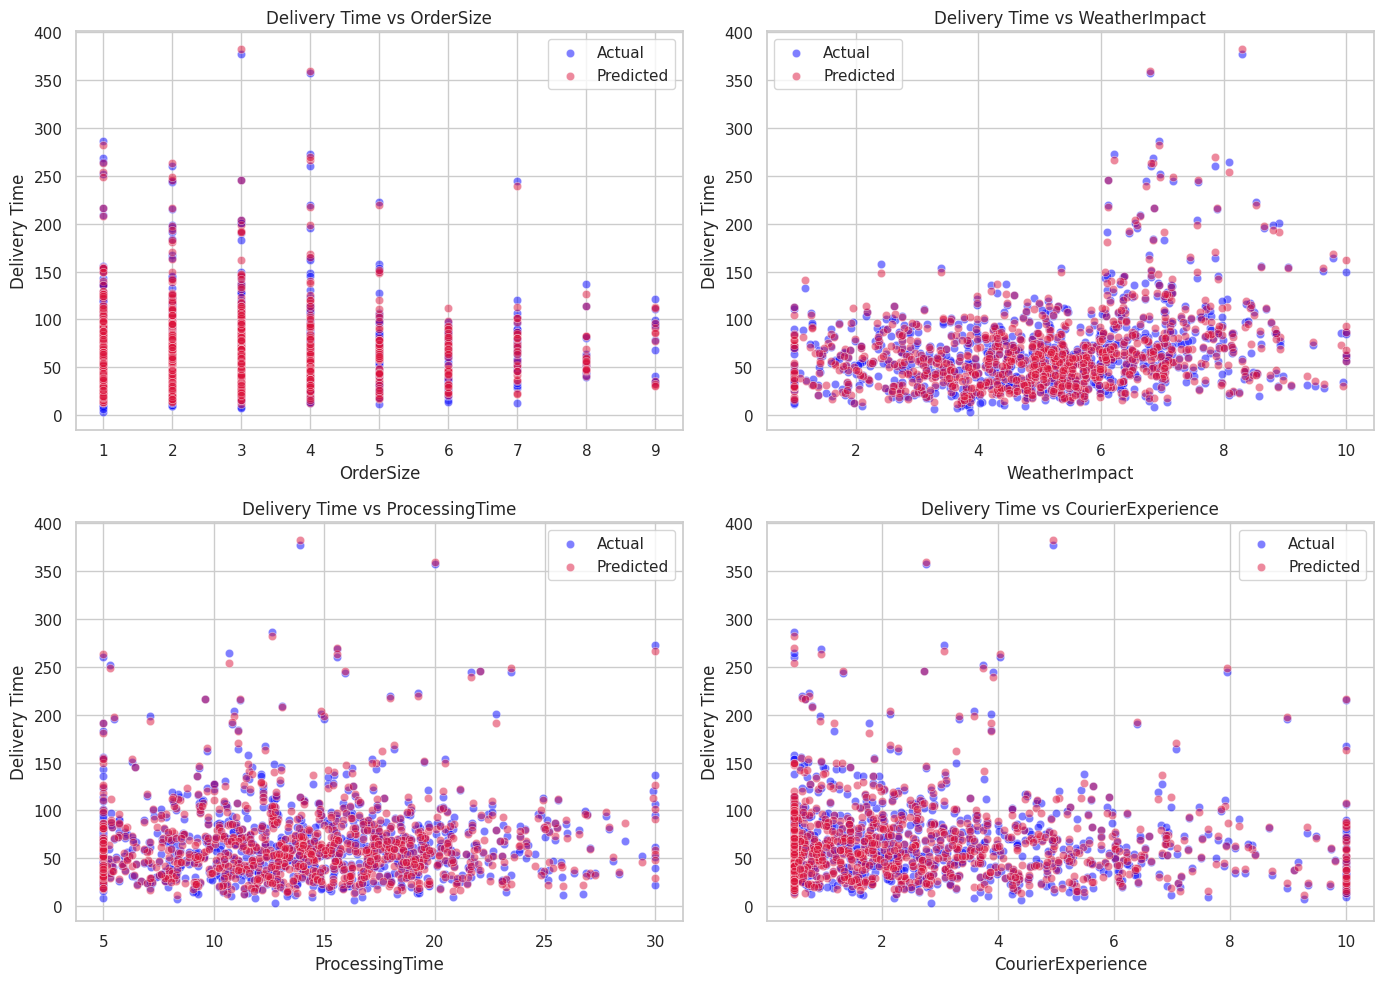

In [ ]:
features_to_plot = ['OrderSize', 'WeatherImpact', 'ProcessingTime', 'CourierExperience']

plt.figure(figsize=(14, 10))
for i, feat in enumerate(features_to_plot, 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(x=X_test[feat], y=y_test, label='Actual', alpha=0.5, color='blue')
    sns.scatterplot(x=X_test[feat], y=y_pred_final, label='Predicted', alpha=0.5, color='crimson')
    plt.xlabel(feat)
    plt.ylabel("Delivery Time")
    plt.title(f"Delivery Time vs {feat}")
    plt.legend()

plt.tight_layout()
plt.show()


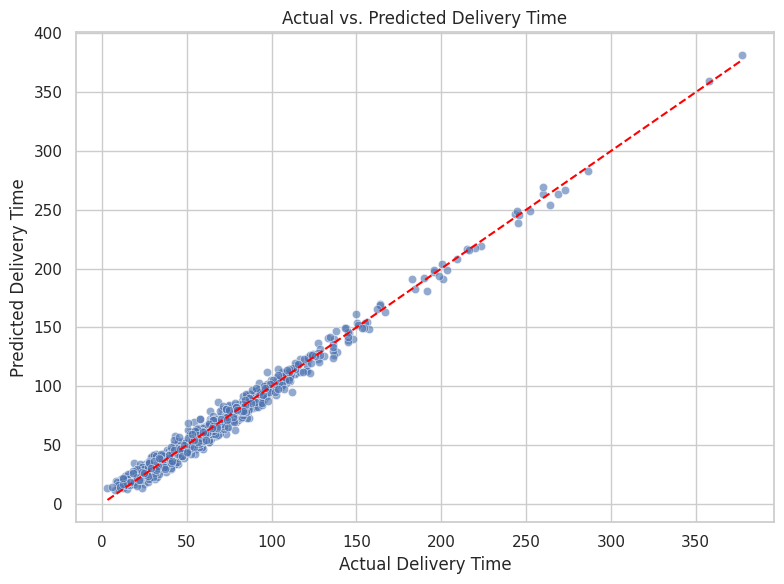

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_final, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual Delivery Time')
plt.ylabel('Predicted Delivery Time')
plt.title('Actual vs. Predicted Delivery Time')
plt.grid(True)
plt.tight_layout()
plt.show()


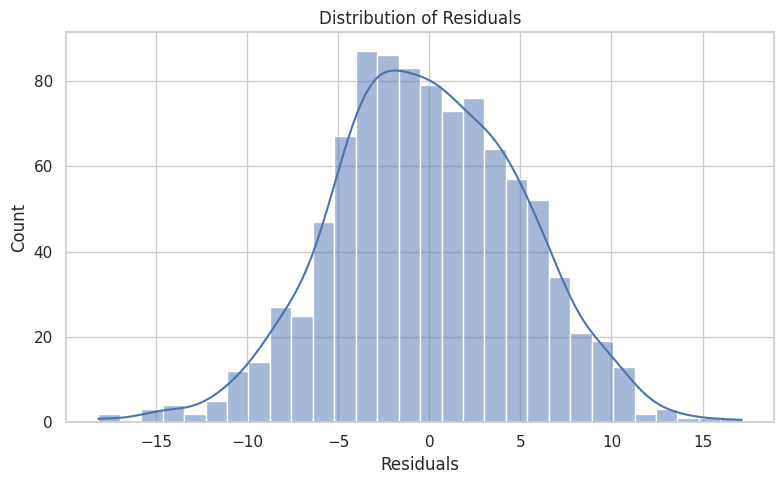

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Distribution of Residuals")
plt.xlabel("Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()


# DOWNLOAD

In [ ]:

final_ridge_model = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('ridge', Ridge(alpha=11.5))
])

final_ridge_model.fit(X, y)


Pipeline(steps=[('scaler', StandardScaler()),
                ('poly', PolynomialFeatures(degree=3, include_bias=False)),
                ('ridge', Ridge(alpha=11.5))])

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving DeliveryTime_test_noLabel.csv to DeliveryTime_test_noLabel.csv


In [ ]:

X = training_data[features]
y = training_data['DeliveryTime']

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge

final_ridge_model = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('ridge', Ridge(alpha=11.5))
])

final_ridge_model.fit(X, y)

test_df = pd.read_csv("DeliveryTime_test_noLabel.csv")

test_df['Distance_Traffic'] = test_df['Distance'] * test_df['TrafficCondition']
test_df['Weather_Weekend'] = test_df['WeatherImpact'] * test_df['WeekendDelivery']

X_test_final = test_df[features]
y_test_pred = final_ridge_model.predict(X_test_final)

submission = pd.DataFrame({'DeliveryTime': y_test_pred})

submission.to_csv('520360707_Assignment1_prediction.csv', index=False)


In [ ]:
from google.colab import files
files.download('520360707_Assignment1_prediction.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Final Submission Cell


In [ ]:
import pandas as pd

DeliveryTime_test = pd.read_csv("DeliveryTime_test.csv")

DeliveryTime_test['Distance_Traffic'] = DeliveryTime_test['Distance'] * DeliveryTime_test['TrafficCondition']
DeliveryTime_test['Weather_Weekend'] = DeliveryTime_test['WeatherImpact'] * DeliveryTime_test['WeekendDelivery']

X_final_test = DeliveryTime_test[features]

y_test_pred = best_model.predict(X_final_test)

test_error = "Test predictions completed – actual test labels unavailable."

print(test_error)
